# Data Science Project 3

- Student Name: Natalya Doris
- Student Pace: Flex / 40 weeks
- Scheduled Project Review Date / Time: 
- Instructor Name: Abhineet Kulkarni
- Blog Post URL: 

## Setup, EDA, Preprocessing

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### Load in Data

In [4]:
df = pd.read_csv('data/investments_VC.csv', encoding = "ISO-8859-1")

### Basic Cleaning

In [5]:
# getting rid of extra spaces in market and funding_total_usd
df = df.rename(columns={' market ': 'market', 
                        ' funding_total_usd ': 'funding_total_usd'})

Dropping irrelevant columns:

In [6]:
df = df.drop(columns=['permalink', 'homepage_url', 'category_list', 
                          'founded_quarter', 'post_ipo_equity',  
                          'post_ipo_debt', 'secondary_market'], 
                 axis=1)

Dropping duplicates, if any:

In [7]:
df = df.drop_duplicates()

In [9]:
df['status'].value_counts()

operating    41829
acquired      3692
closed        2603
Name: status, dtype: int64

### Exploratory Analysis - Full Dataset

In [10]:
data = df

In [11]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49439 entries, 0 to 49438
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  49437 non-null  object 
 1   market                45470 non-null  object 
 2   funding_total_usd     49438 non-null  object 
 3   status                48124 non-null  object 
 4   country_code          44165 non-null  object 
 5   state_code            30161 non-null  object 
 6   region                44165 non-null  object 
 7   city                  43322 non-null  object 
 8   funding_rounds        49438 non-null  float64
 9   founded_at            38554 non-null  object 
 10  founded_month         38482 non-null  object 
 11  founded_year          38482 non-null  float64
 12  first_funding_at      49438 non-null  object 
 13  last_funding_at       49438 non-null  object 
 14  seed                  49438 non-null  float64
 15  venture            

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,private_equity,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,#waywire,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,&TV Communications,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Rock' Your Paper,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(In)Touch Network,Electronics,"15,00,000",operating,GBR,NaN,London,London,1.0,2011-04-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-R- Ranch and Mine,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1000]:
data.isnull().sum()

name                        2
market                   3969
funding_total_usd           1
status                   1315
country_code             5274
state_code              19278
region                   5274
city                     6117
funding_rounds              1
founded_at              10885
founded_month           10957
founded_year            10957
first_funding_at            1
last_funding_at             1
seed                        1
venture                     1
equity_crowdfunding         1
undisclosed                 1
convertible_note            1
debt_financing              1
angel                       1
grant                       1
private_equity              1
product_crowdfunding        1
round_A                     1
round_B                     1
round_C                     1
round_D                     1
round_E                     1
round_F                     1
round_G                     1
round_H                     1
dtype: int64

In [12]:
data['founded_at'].head()

0    2012-06-01
1           NaN
2    2012-10-26
3    2011-04-01
4    2014-01-01
Name: founded_at, dtype: object

In [13]:
data['region'].value_counts()

SF Bay Area            6804
New York City          2577
Boston                 1837
London                 1588
Los Angeles            1389
                       ... 
Marbella                  1
Maroúli                   1
Norrkoping                1
Kolding                   1
Castelfranco Veneto       1
Name: region, Length: 1089, dtype: int64

In [14]:
data['city'].value_counts()

San Francisco    2615
New York         2334
London           1257
Palo Alto         597
Austin            583
                 ... 
Hobe Sound          1
Millbrook           1
Noordwijk           1
Slinfold            1
Orland Park         1
Name: city, Length: 4188, dtype: int64

In [15]:
data['state_code'].value_counts()

CA    9917
NY    2914
MA    1969
TX    1466
WA     974
      ... 
MB      13
AK      12
NB       8
SK       4
PE       2
Name: state_code, Length: 61, dtype: int64

In [173]:
data['country_code'].value_counts()

USA    28233
na      5066
GBR     2595
CAN     1351
CHN     1229
       ...  
LIE        1
JAM        1
UZB        1
MAF        1
MUS        1
Name: country_code, Length: 116, dtype: int64

In [13]:
data['secondary_market'].value_counts()

0.0            49419
200000000.0        1
7343789.0          1
20000000.0         1
12500000.0         1
126700000.0        1
680611554.0        1
400000000.0        1
63750000.0         1
19300000.0         1
4700000.0          1
78800355.0         1
210000000.0        1
2500000.0          1
156929.0           1
700000.0           1
7718867.0          1
6192396.0          1
210000.0           1
60000000.0         1
Name: secondary_market, dtype: int64

In [16]:
# inspecting market feature - lots of catgories
print("Number of unique markets: ", len(set(data['market'])))
print("Markets with more than 200 companies: ",      
      str(sum(data['market'].value_counts() >= 200)))

Number of unique markets:  754
Markets with more than 200 companies:  39


<AxesSubplot:>

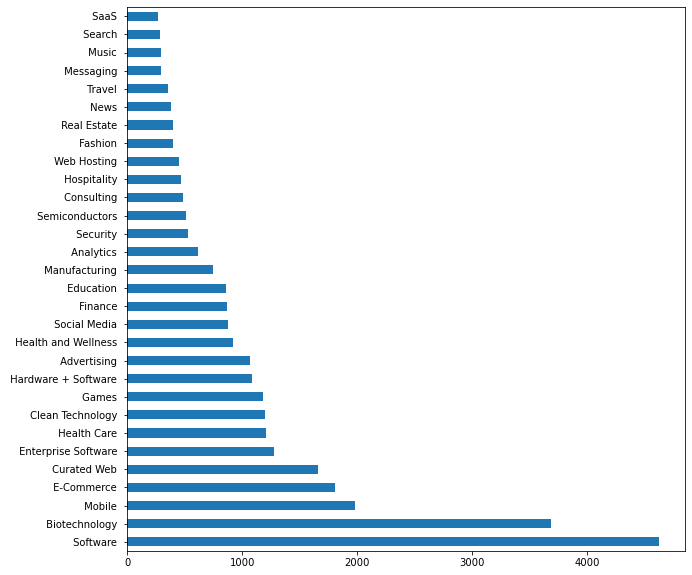

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
data['market'].value_counts()[:30].plot(kind='barh')

In [18]:
# same deal with region
print("Number of unique regions: ", len(set(data['region'])))
print("Regions with more than 200 companies: ",      
      str(sum(data['region'].value_counts() >= 200)))

Number of unique regions:  1090
Regions with more than 200 companies:  44


<AxesSubplot:>

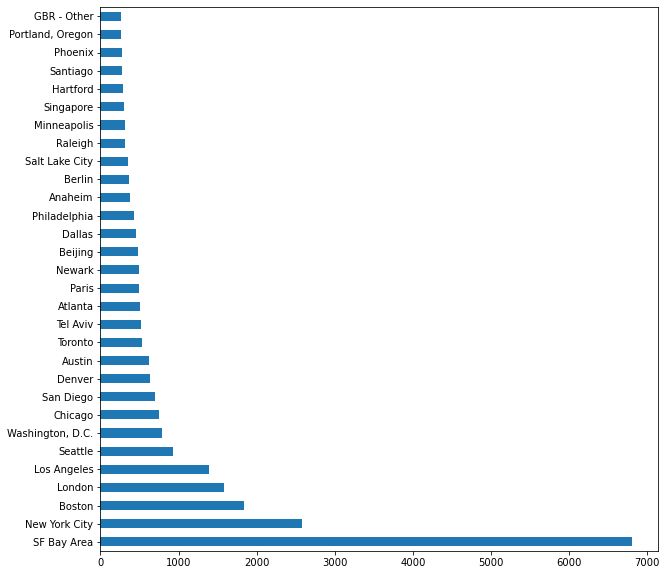

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
data['region'].value_counts()[:30].plot(kind='barh')

array([[<AxesSubplot:title={'center':'equity_crowdfunding'}>]],
      dtype=object)

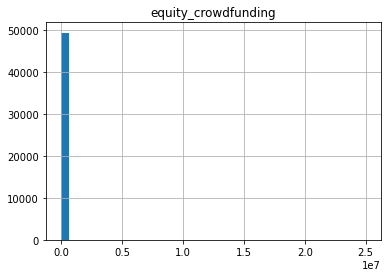

In [21]:
data.hist('equity_crowdfunding', bins=40) 
# there are some very skewed columns in the funding area

### Preprocessing & Feature Engineering

In [22]:
data.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_year', 'first_funding_at', 'last_funding_at',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

#### Missing Values

* I am removing rows with missing status or company name. 
* I am also dropping rows with a missing founded_year because this feature has high importance in many of the models & thus would prefer not to impute at risk of skewing the model. I tried both dropping and keeping  the missing founded_years (imputed). The proportion of companies in each status category & model results are fairly similar with & without imputing the median of year so I am comfortable dropping these rows.

In [23]:
data = data.dropna(subset=['status', 'name', 'founded_year'])
data.isnull().sum()

name                        0
market                   1801
funding_total_usd           0
status                      0
country_code             2936
state_code              13332
region                   2936
city                     3357
funding_rounds              0
founded_at                  0
founded_month               0
founded_year                0
first_funding_at            0
last_funding_at             0
seed                        0
venture                     0
equity_crowdfunding         0
undisclosed                 0
convertible_note            0
debt_financing              0
angel                       0
grant                       0
private_equity              0
product_crowdfunding        0
round_A                     0
round_B                     0
round_C                     0
round_D                     0
round_E                     0
round_F                     0
round_G                     0
round_H                     0
dtype: int64

In [24]:
len(data)

37563

In [25]:
# filling categoricals
data = data.fillna(value={'market': 'other', 'country_code': 'other', 
                          'region': 'other', 'city': 'other', 
                          'state_code': 'other'})

10th percentile of founded_year:  2000.0
Num Rows before 2000:  3518


34045

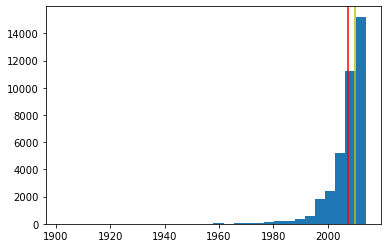

In [26]:
# distribution of non NA years 
plt.hist(data['founded_year'][~data['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data['founded_year']), color='y')

p10 = np.percentile(data['founded_year'][~data['founded_year'].isnull()], 10)
print("10th percentile of founded_year: ", p10)

#10th percentile year is 2000, we will subset for startups founded on or after 2000
print("Num Rows before 2000: ", len(data[data['founded_year'] < 2000]))
data = data[data['founded_year'] >= 2000].reset_index(drop=True)
len(data)

In [43]:
len(df[(df['founded_year'] < 2000) & (df['status'] != 'operating')])

838

Date data - convert to datetime:

In [27]:
data['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                      in data['founded_at'][~data['founded_at'].isnull()]]
data['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                            in data['first_funding_at']]
data['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                            in data['last_funding_at']]
data['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data['founded_month']]

Fill year & founded_at with simple imputer (only if not removing NaN rows). Since the data is skewed (see plot above), we will use median rather than mean.

In [636]:
# uncomment the below to impute founded_year with mean, only if we are not 
# dropping nans for this feature

#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

#data['founded_year'] = imp_median.fit_transform(data[['founded_year']])
#data['founded_at'] = imp_median.fit_transform(data[['founded_at']])

In [28]:
data['founded_at'] = pd.to_datetime(data['founded_at'])
data['founded_year'] = [day.year for day in data['founded_at']]

In [29]:
data['founded_at'].value_counts()

2012-01-01    2100
2011-01-01    2096
2010-01-01    1810
2009-01-01    1561
2013-01-01    1535
              ... 
2004-04-25       1
2009-08-12       1
2014-08-04       1
2002-08-02       1
2010-11-06       1
Name: founded_at, Length: 2935, dtype: int64

In [30]:
data.isna().sum()

name                    0
market                  0
funding_total_usd       0
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
founded_month           0
founded_year            0
first_funding_at        0
last_funding_at         0
seed                    0
venture                 0
equity_crowdfunding     0
undisclosed             0
convertible_note        0
debt_financing          0
angel                   0
grant                   0
private_equity          0
product_crowdfunding    0
round_A                 0
round_B                 0
round_C                 0
round_D                 0
round_E                 0
round_F                 0
round_G                 0
round_H                 0
dtype: int64

Basic data cleaning:

In [31]:
# getting rid of extra spaces in market, city, state code, region
data['market'] = [x.strip() for x in data['market']]
data['country_code'] = [x.strip() for x in data['country_code']]
data['state_code'] = [x.strip() for x in data['state_code']]
data['region'] = [x.strip() for x in data['region']]
data['city'] = [x.strip() for x in data['city']]

In [1008]:
data.dtypes

name                            object
market                          object
funding_total_usd               object
status                          object
country_code                    object
state_code                      object
region                          object
city                            object
funding_rounds                 float64
founded_at              datetime64[ns]
founded_month                   object
founded_year                     int64
first_funding_at                object
last_funding_at                 object
seed                           float64
venture                        float64
equity_crowdfunding            float64
undisclosed                    float64
convertible_note               float64
debt_financing                 float64
angel                          float64
grant                          float64
private_equity                 float64
product_crowdfunding           float64
round_A                        float64
round_B                  

In [1025]:
# need to convert this data type to integer
data['funding_total_usd'].value_counts()

 -               5632
 10,00,000        627
 1,00,000         582
 5,00,000         573
 40,000           466
                 ... 
 2,46,97,455        1
 15,42,386          1
 59,70,053          1
 9,88,17,742        1
 3,88,99,998        1
Name: funding_total_usd, Length: 10560, dtype: int64

In [34]:
data['funding_total_usd'] = [float(num.replace(" ", "0").replace(",", "0").\
                                   replace("-", "0")) 
                             for num in data['funding_total_usd']]
data['funding_total_usd'].dtypes

dtype('float64')

#### Feature Engineering

In [35]:
# creating column that labels country as domestic or international
data['international'] = [0 if country=='USA' else 1 for country in data['country_code']]

In [36]:
# creating temporary columns to aid in calculation of time to first funding

data['founded_at_temp'] = [day.date() for day in data['founded_at']]
data['founded_at_temp'] = pd.to_datetime(data['founded_at_temp'], 
                                         format = '%Y-%m-%d')

data['first_funding_at_temp'] = pd.to_datetime(data['first_funding_at'], 
                                               format = '%Y-%m-%d', 
                                               errors='coerce')
data['last_funding_at_temp'] = pd.to_datetime(data['last_funding_at'], 
                                              format = '%Y-%m-%d', 
                                              errors='coerce')

data['time_to_first_funding'] = (data['first_funding_at_temp'] - \
                                 data['founded_at_temp']) / pd.Timedelta(days=365)

data['time_first_to_last_funding'] = (data['last_funding_at_temp'] - \
                                      data['first_funding_at_temp']) / pd.Timedelta(days=365)

In [37]:
# checking for nulls
print(data['first_funding_at'][data['time_to_first_funding'].isnull()])
print(data['last_funding_at'][data['time_first_to_last_funding'].isnull()])

1030     0020-06-14
4514     0019-11-20
9863     0201-01-01
20287    0007-05-13
21784    0001-05-14
Name: first_funding_at, dtype: object
1030     2013-06-01
4514     2013-04-01
9863     0201-01-01
20287    2014-09-25
21784    0001-05-14
Name: last_funding_at, dtype: object


In [38]:
# dropping these
data = data.dropna(subset=['time_to_first_funding'])

#### OPTIONAL - Outliers

408206869399.0
32338
34040


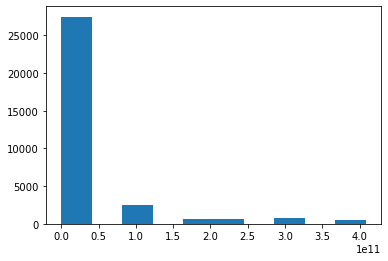

In [718]:
# Funding total USD
print(np.percentile(data['funding_total_usd'], 95))

plt.hist(data['funding_total_usd'][data['funding_total_usd'] < 408206869399.0])
print(len(data[data['funding_total_usd'] < 408206869399.0]))
print(len(data))

32301
31990
34040


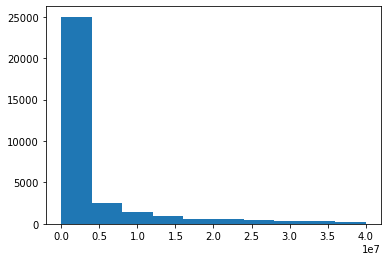

In [717]:
np.percentile(data['venture'], 95)

plt.hist(data['venture'][data['venture'] < 40000000.0])
print(len(data[data['venture'] < 40000000.0]))
print(len(data[(data['venture'] < 40000000.0) & 
               (data['funding_total_usd'] < 408206869399.0)]))
print(len(data))

In [ ]:
### THIS DOESN'T HELP THE MODELS, SO I COMMENTED THIS OUT

In [719]:
# uncomment to remove outliers

#data = data[(data['venture'] < 40000000.0) & 
#            (data['funding_total_usd'] < 408206869399.0)].reset_index(drop=True)
#len(data)

31990

#### Correlations

Based on the below, the strongest correlations occur between debt_financing and funding_total_usd, round_H and round_G, followed by venture and all of the rounds of funding

Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Status)')

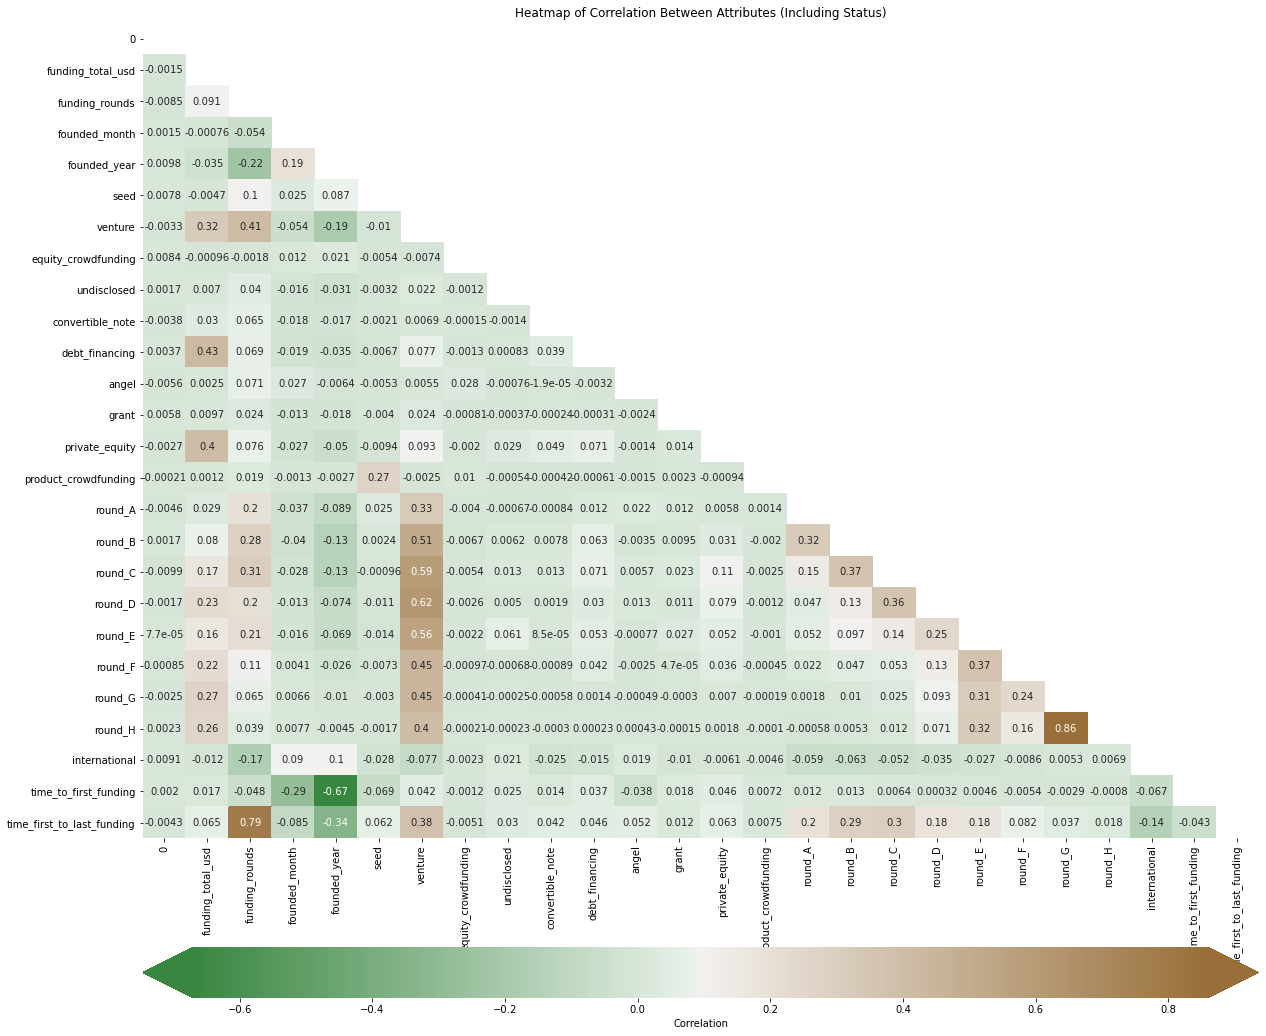

In [39]:
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data['status'])), 
                          data.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

In [40]:
#data_corr=data.drop(columns=['status'], axis=1).corr()
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

,cc
pairs,
"(round_H, round_G)",0.859849
"(time_first_to_last_funding, funding_rounds)",0.793787


In [139]:
# dropping temp columns 
data = data.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                          'first_funding_at_temp', 'last_funding_at_temp', 
                          'founded_at_temp'], axis=1).reset_index(drop=True)

# creating csv file to work from
data.to_csv('data/final_working_data.csv')

In [ ]:
# dropping columns with correlation coefficient greater than 0.7
data_uncorr = data.drop(columns=['round_H', 'time_first_to_last_funding'], 
                        axis=1).reset_index(drop=True)

#renaming full dataset
data_full = data

#### OPTIONAL - Binary Representation of Funding Rounds

In [497]:
# data['had_round_A'] = [0 if x==0 else 1 for x in data['round_A']]
# data['had_round_B'] = [0 if x==0 else 1 for x in data['round_B']]
# data['had_round_C'] = [0 if x==0 else 1 for x in data['round_C']]
# data['had_round_D'] = [0 if x==0 else 1 for x in data['round_D']]
# data['had_round_E'] = [0 if x==0 else 1 for x in data['round_E']]
# data['had_round_F'] = [0 if x==0 else 1 for x in data['round_F']]
# data['had_round_G'] = [0 if x==0 else 1 for x in data['round_G']]
# data['had_venture'] = [0 if x==0 else 1 for x in data['venture']]
# data['had_seed'] = [0 if x==0 else 1 for x in data['seed']]
# data['had_eq_crowdfunding'] = [0 if x==0 else 1 for x in data['equity_crowdfunding']]
# data['had_pd_crowdfunding'] = [0 if x==0 else 1 for x in data['product_crowdfunding']]
# data['had_angel'] = [0 if x==0 else 1 for x in data['angel']]
# data['had_grant'] = [0 if x==0 else 1 for x in data['grant']]
# data['had_pe'] = [0 if x==0 else 1 for x in data['private_equity']]
# data['had_convert'] = [0 if x==0 else 1 for x in data['convertible_note']]

## Functions

#### train_test_preprocess

In [1]:
''' 
Function to perform train_test_split and necessary preprocessing / scaling
'''

def train_test_preprocess(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # check that there are the same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]
    
    # Categorizing features in preparation for scaling / encoding
    X_train_cat_eng = X_train.select_dtypes(include=['int64']).reset_index(drop=True)
    X_test_cat_eng = X_test.select_dtypes(include=['int64']).reset_index(drop=True)

    X_train_cont = X_train.select_dtypes(exclude=['object','int64']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object','int64']).reset_index(drop=True)

    cat_columns = ['market', 'region']
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Min Max Scaler:
    scaler = MinMaxScaler() # instantiate MinMaxScaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont, X_train_cat_eng], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled, X_train_cat_eng], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled, X_test_cat_eng], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont, X_test_cat_eng], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

#### print_scores

In [81]:
''' 
Function to print relevant scoring metrics
'''

def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Testing Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Testing F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_hat_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('ROC AUC: ', roc_auc)
        print('PR AUC: ', average_precision_score(y_test, y_hat_test))
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

#### return_scores

In [82]:
''' 
Function that stores relevant scoring metrics
'''

def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    r_train = recall_score(y_train, y_hat_train)
    r_test = recall_score(y_test, y_hat_test)
         
    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

#### train_test_check

In [ ]:
''' 
Function that checks new train & test splits for proper shape
'''

def train_test_check(X_train_processed, X_train_scaled, X_test_processed, 
                     X_test_scaled, y_train, y_test):
    
    assert X_train_processed.shape[0] == y_train.shape[0]
    assert X_train_scaled.shape[0] == y_train.shape[0]
    
    assert X_test_processed.shape[0] == y_test.shape[0]
    assert X_test_scaled.shape[0] == y_test.shape[0]

    print("There are {} features in train set".format(len(X_train_processed.columns)))
    print("There are {} features in test set".format(len(X_test_processed.columns)))

    print("There are {} features in train set (scaled)".format(len(X_train_scaled.columns)))
    print("There are {} features in test set (scaled)".format(len(X_test_scaled.columns)))
    
    print(f"y_train is a Series with {y_train.shape[0]} values")
    print("target breakdown: ", y_train.value_counts(normalize=True))

    display(X_train_processed.head())
    display(X_train_scaled.head())

#### correlation_check

In [937]:
''' 
Function that checks for excessive correlations across features
'''
def correlation_check(X_train_preprocessed):
    
    df_corr=X_train_processed.corr()

    df = df_corr.abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # cc for correlation coefficient
    df.columns = ['cc']
    df.drop_duplicates(inplace=True)

    display(df[(df.cc>.5) & (df.cc<1)])

,cc
pairs,
"(round_E, round_F)",0.734840
"(round_F, debt_financing)",0.721803
"(venture, round_B)",0.710362
"(venture, round_C)",0.672736
"(founded_year, time_to_first_funding)",0.640687
"(round_E, debt_financing)",0.598267
"(international, region_other)",0.578850
"(round_D, venture)",0.542664
"(round_A, round_B)",0.541239


# Acquired or Closed Dataset

In [44]:
data_ac = df[df['status'] != 'operating']

## EDA / Preprocessing

In [45]:
data_ac.isnull().sum()

name                       2
market                   611
funding_total_usd          1
status                  1315
country_code             835
state_code              2582
region                   835
city                     951
funding_rounds             1
founded_at              1720
founded_month           1725
founded_year            1725
first_funding_at           1
last_funding_at            1
seed                       1
venture                    1
equity_crowdfunding        1
undisclosed                1
convertible_note           1
debt_financing             1
angel                      1
grant                      1
private_equity             1
product_crowdfunding       1
round_A                    1
round_B                    1
round_C                    1
round_D                    1
round_E                    1
round_F                    1
round_G                    1
round_H                    1
dtype: int64

In [46]:
len(data_ac)

7610

In [47]:
data_ac = data_ac.dropna(subset=['status', 'name'])
len(data_ac)

6294

In [48]:
data_ac['status'].value_counts(normalize=True)

acquired    0.58659
closed      0.41341
Name: status, dtype: float64

In [49]:
# filling categoricals
data_ac = data_ac.fillna(value={'market': 'other', 'country_code': 'other', 
                                'region': 'other', 'city': 'other', 
                                'state_code': 'other'})

1st percentile of founded_year:  1982.0
Num Rows before 1980:  35


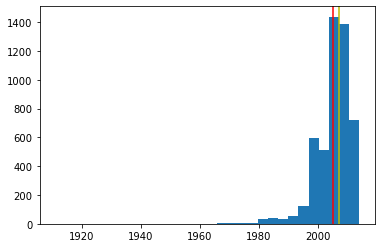

In [50]:
# distribution of non NA years 
plt.hist(data_ac['founded_year'][~data_ac['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data_ac['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data_ac['founded_year']), color='y')

p1 = np.percentile(data_ac['founded_year'][~data_ac['founded_year'].isnull()], 1)
print("1st percentile of founded_year: ", p1)

#1980 looks like a good cutoff point
print("Num Rows before 1980: ", len(data_ac[data_ac['founded_year'] < 1980]))
data_ac = data_ac[data_ac['founded_year'] >= 1980].reset_index(drop=True)

In [51]:
data_ac['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                         in data_ac['founded_at'][~data_ac['founded_at'].isnull()]]
data_ac['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                               in data_ac['first_funding_at']]
data_ac['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                              in data_ac['last_funding_at']]
data_ac['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data_ac['founded_month']]

In [52]:
# imputing median for day, then pulling founded year and month from that
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

data_ac['founded_at'] = imp_median.fit_transform(data_ac[['founded_at']])

data_ac['founded_at'] = pd.to_datetime(data_ac['founded_at'])
data_ac['founded_year'] = [day.year for day in data_ac['founded_at']]
data_ac['founded_month'] = [day.month for day in data_ac['founded_at']]

In [53]:
# creating column that labels country as domestic or international
data_ac['international'] = [0 if country=='USA' else 1 for country in data_ac['country_code']]

In [54]:
# creating temporary columns to aid in calcuation of time to first funding

data_ac['founded_at_temp'] = [day.date() for day in data_ac['founded_at']]
data_ac['founded_at_temp'] = pd.to_datetime(data_ac['founded_at_temp'], 
                                            format = '%Y-%m-%d')

data_ac['first_funding_at_temp'] = pd.to_datetime(data_ac['first_funding_at'], 
                                                  format = '%Y-%m-%d', 
                                                  errors='coerce')
data_ac['last_funding_at_temp'] = pd.to_datetime(data_ac['last_funding_at'], 
                                                 format = '%Y-%m-%d', 
                                                 errors='coerce')

data_ac['time_to_first_funding'] = (data_ac['first_funding_at_temp'] - \
                                    data_ac['founded_at_temp']) / pd.Timedelta(days=365)

data_ac['time_first_to_last_funding'] = (data_ac['last_funding_at_temp'] - \
                                         data_ac['first_funding_at_temp']) / pd.Timedelta(days=365)

In [55]:
# checking for nulls
print(data_ac['first_funding_at'][data_ac['time_to_first_funding'].isnull()])
print(data_ac['last_funding_at'][data_ac['time_first_to_last_funding'].isnull()])

3697    0011-11-14
Name: first_funding_at, dtype: object
3697    2012-07-24
Name: last_funding_at, dtype: object


In [56]:
data_ac = data_ac.dropna(subset=['time_to_first_funding']).reset_index(drop=True)

Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Status)')

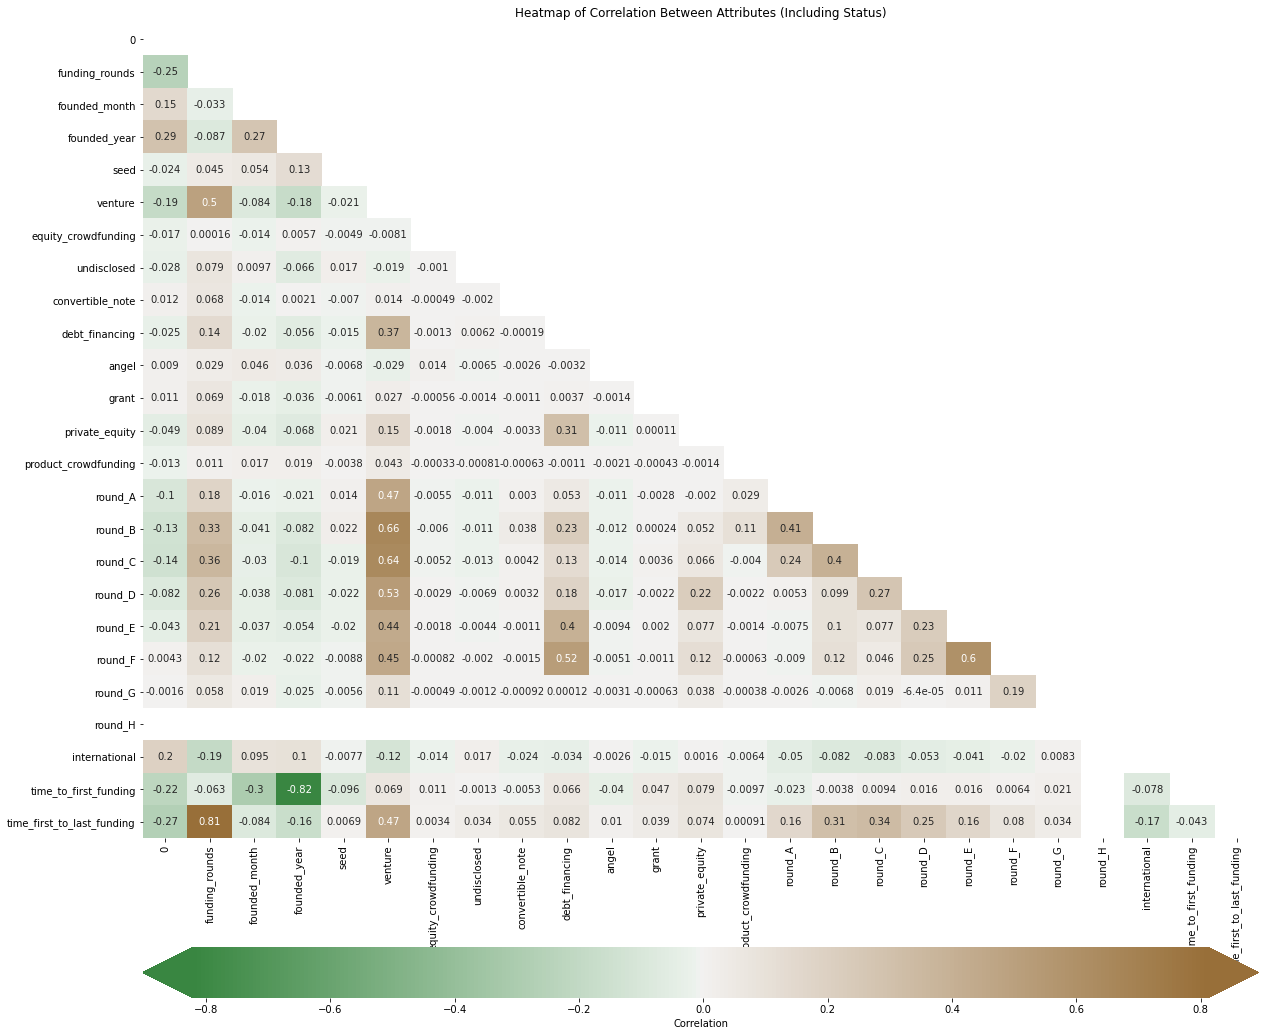

In [57]:
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data_ac['status'])), 
                          data_ac.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

In [58]:
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

,cc
pairs,
"(founded_year, time_to_first_funding)",0.819908
"(time_first_to_last_funding, funding_rounds)",0.812019


In [71]:
# reducing number of categories in market & region

print(sum(data_ac['market'].value_counts() >= 15))
data_ac['market'][data_ac['market'].map(data_ac['market'].value_counts()) < 15] = 'other'
print(data_ac['market'].value_counts())

print(sum(data_ac['region'].value_counts() >= 60))
data_ac['region'][data_ac['region'].map(data_ac['region'].value_counts()) < 60] = 'other'
print(data_ac['region'].value_counts())

48
other                      1162
 Software                   569
 Curated Web                347
 Mobile                     281
 Enterprise Software        200
 Biotechnology              189
 Advertising                173
 Games                      172
 E-Commerce                 164
 Social Media               136
 Hardware + Software        100
 Semiconductors              96
 Security                    92
 Web Hosting                 84
 Clean Technology            78
 Health Care                 75
 Finance                     71
 Analytics                   59
 Messaging                   55
 Search                      54
 News                        47
 Music                       45
 Education                   43
 Public Relations            42
 Video                       41
 Travel                      40
 Networking                  38
 Photography                 36
 Social Network Media        34
 Consulting                  33
 Health and Wellness         32
 SaaS

In [72]:
# dropping correlated columns for logistic regression, which can be
# sensitive to correlated features
data_final = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                   'first_funding_at_temp', 'last_funding_at_temp', 
                                   'founded_at_temp', 'round_H', 'founded_year',  
                                   'time_first_to_last_funding'], 
                       axis=1)
# all inclusive
data_final2 = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                    'first_funding_at_temp', 'last_funding_at_temp', 
                                    'founded_at_temp', 'round_H'], 
                       axis=1)

In [73]:
data_final.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding'],
      dtype='object')

In [74]:
data_final2.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding', 'time_first_to_last_funding'],
      dtype='object')

## X/Y Split

In [75]:
X_ac_lr = data_final.drop(columns=['status', 'name', 'country_code', 
                                   'state_code', 'city'], axis=1)

encoder = LabelEncoder()
y_ac_lr = pd.Series(encoder.fit_transform(data_final['status'])) 
# acquired is 0, closed is 1

y_ac_lr.value_counts(normalize=True)

0    0.59716
1    0.40284
dtype: float64

In [76]:
X_ac = data_final2.drop(columns=['status', 'name', 'country_code', 'state_code', 
                             'city'], axis=1)

encoder = LabelEncoder()
y_ac = pd.Series(encoder.fit_transform(data_final2['status'])) 
# acquired is 0, closed is 1

y_ac.value_counts(normalize=True)

0    0.59716
1    0.40284
dtype: float64

## Baseline Model

In [77]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac_lr, y_ac_lr)

In [78]:
print("There are {} features in train set".format(len(X_train_processed.columns)))
print("There are {} features in test set".format(len(X_test_processed.columns)))

print("There are {} features in train set (scaled)".format(len(X_train_scaled.columns)))
print("There are {} features in test set (scaled)".format(len(X_test_scaled.columns)))

There are 82 features in train set
There are 82 features in test set
There are 82 features in train set (scaled)
There are 82 features in test set (scaled)


In [79]:
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [83]:
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.5843981170141224
Testing Recall:  0.5571142284569138


Training F1:  0.6329206117989803
Testing F1:  0.601081081081081


ROC AUC:  0.6777396755363587
PR AUC:  0.5428004381562778


Training Accuracy:  0.7273464971598593
Testing Accuracy:  0.7007299270072993


### Baseline Analysis

* point A
* point B
* point C

### Grid Search on Baseline

In [84]:
param_grid = {'penalty':['l2', None],
              'solver':['lbfgs', 'sag'],
              'C': [1.0, 1e12], 
              'class_weight': [None, 'balanced']
             }

In [85]:
grid_logreg = GridSearchCV(baseline_model, param_grid, cv = 5, 
                           scoring='recall') # macro or weighted
grid_logreg.fit(X_train_scaled, y_train)
grid_logreg.best_params_

{'C': 1000000000000.0,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [86]:
y_preds_grid_lr_train = grid_logreg.predict(X_train_scaled)
y_preds_grid_lr = grid_logreg.predict(X_test_scaled)

print_scores(y_train, y_preds_grid_lr_train, y_test, y_preds_grid_lr)

Training Recall:  0.753866845998655
Testing Recall:  0.7114228456913828


Training F1:  0.6812518991188088
Testing F1:  0.6472196900638104


ROC AUC:  0.6901800876958277
PR AUC:  0.5391212814027342


Training Accuracy:  0.7162564241276711
Testing Accuracy:  0.6861313868613139


## Custom Pipeline

In [87]:
scores = pd.DataFrame(columns = ['recall_train', 'recall_test', 'f1_train', 
                                 'f1_test', 'accuracy_train', 'accuracy_test', 
                                 'roc_auc', 'pr_auc', 'params'])

In [88]:
# creates a data frame with various scores for each model
def customPipe(model, model_name, X, y):
    X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
    y_train, y_test = train_test_preprocess(X, y)
    
    if ('lr' in model_name) | ('knn' in model_name):
    #(model_name == 'lr') | (model_name == 'knn'):
        model.fit(X_train_scaled, y_train)
        y_hat_train = model.predict(X_train_scaled)
        y_hat_test = model.predict(X_test_scaled)

    else:
        model.fit(X_train_processed, y_train)
        y_hat_train = model.predict(X_train_processed)
        y_hat_test = model.predict(X_test_processed)
    
    r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc = \
    return_scores(y_train, y_hat_train, y_test, y_hat_test)
    
    score_list = []
    score_list.extend((r_train, r_test, f1_train, f1_test, 
                       ac_train, ac_test, roc_auc, pr_auc, str(model)))
    
    scores.loc[model_name] = score_list
    return scores

In [91]:
# model inputs
lr = LogisticRegression(random_state=42, class_weight='balanced', solver='sag')
rf = RandomForestClassifier(random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
ext = ExtraTreesClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
knn = KNeighborsClassifier()

In [92]:
# running the function
customPipe(lr, 'lr_base', X_ac_lr, y_ac_lr)
customPipe(rf, 'rf', X_ac, y_ac)
customPipe(dtc, 'dtc', X_ac, y_ac)
customPipe(ext, 'ext', X_ac, y_ac)
customPipe(xgb, 'xgb', X_ac, y_ac)
customPipe(knn, 'knn', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.750504,0.711423,0.678626,0.644868,0.714093,0.682887,0.687455,0.536315,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.595190,1.000000,0.645652,1.000000,0.735604,0.713127,0.583713,RandomForestClassifier(random_state=42)
dtc,1.000000,0.551102,1.000000,0.554435,1.000000,0.641525,0.627050,0.489081,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.573146,1.000000,0.612420,1.000000,0.706407,0.685075,0.549577,ExtraTreesClassifier(random_state=42)
xgb,0.911903,0.605210,0.907327,0.626556,0.925074,0.708029,0.691570,0.552834,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()


Looking at recall and accuracy, the Random Forest and XGBoost models seem to yield the best scores. Will hyper tune each of these models.

In [93]:
# storing dataframe for easy access
scores_base = scores # models pre hyper parameter tuning

## Other Models - Hypertuning

### Random Forest

In [111]:
rf = RandomForestClassifier(random_state=42)

# Initial search
rf_param_grid = {
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[8,12,20],
    'min_samples_leaf': [5,10],
    'class_weight': [None, 'balanced']
}

# Fine tuning
rf_param_grid2 = {
    'criterion':['gini'],
    'max_depth':[20,25],
    'min_samples_leaf': [10,15,20],
    'class_weight': ['balanced'],
    'n_estimators': [100, 200]
}

grid_rfc = GridSearchCV(rf, rf_param_grid2, cv = 5, scoring='recall') 
grid_rfc.fit(X_train_processed, y_train)

grid_rfc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 15,
 'n_estimators': 100}

In [113]:
rf_best = RandomForestClassifier(random_state = 42, class_weight='balanced', 
                                 criterion='gini', max_depth=20, #12
                                 min_samples_leaf=15, n_estimators=100) #100
customPipe(rf_best, 'rf_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.750504,0.711423,0.678626,0.644868,0.714093,0.682887,0.687455,0.536315,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.595190,1.000000,0.645652,1.000000,0.735604,0.713127,0.583713,RandomForestClassifier(random_state=42)
dtc,1.000000,0.551102,1.000000,0.554435,1.000000,0.641525,0.627050,0.489081,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.573146,1.000000,0.612420,1.000000,0.706407,0.685075,0.549577,ExtraTreesClassifier(random_state=42)
xgb,0.911903,0.605210,0.907327,0.626556,0.925074,0.708029,0.691570,0.552834,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.741762,0.711423,0.708641,0.685328,0.754666,0.735604,0.731733,0.587096,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.815064,0.811623,0.708151,0.694683,0.729781,0.711273,0.727338,0.569052,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.760592,0.705411,0.723377,0.669202,0.766027,0.717762,0.715784,0.568235,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.738399,0.735471,0.701149,0.689202,0.746822,0.731549,0.732177,0.583943,DecisionTreeClassifier(class_weight='balanced'...


#### Feature Importance

In [97]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, rf_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_rf = pd.DataFrame(feats.items())

feats_rf.columns = ['col', 'feat_importance']
feats_rf = feats_rf.sort_values(by=['feat_importance'], ascending=False)
feats_rf_20 = feats_rf[:20]
feats_rf_30 = feats_rf[:30]

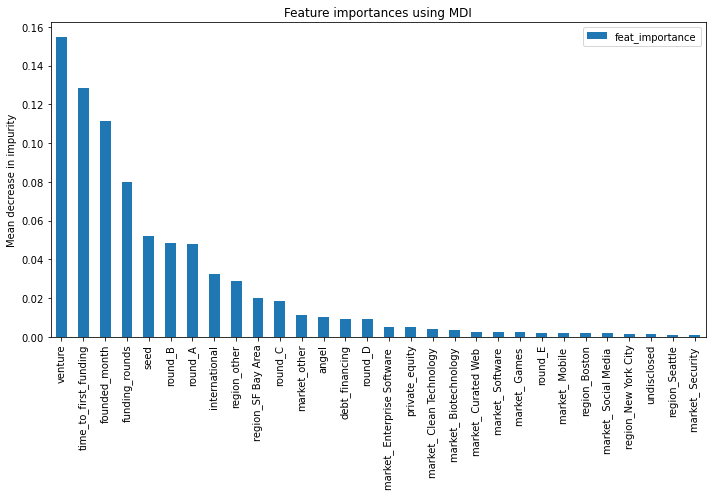

In [99]:
fig, ax = plt.subplots(figsize = (10,7))
feats_rf_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_rf_30['col'])
fig.tight_layout()

In [1420]:
list(feats_rf['col'][:10])

['venture',
 'founded_month',
 'funding_rounds',
 'time_to_first_funding',
 'round_B',
 'round_A',
 'international',
 'round_C',
 'seed',
 'region_other']

### XG Boost**

In [1303]:
# 45+ runtime
xgb = XGBClassifier(random_state=42)

# initial grid search
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4,6,8],
    'min_child_weight': [3,5,7],
    'subsample': [0.5, 0.7],
    'scale_pos_weight':[1.5,2]
}

# fine tuning
xgb_param_grid2 = {
    'learning_rate': [0.1],
    'max_depth': [1,2,4],
    'min_child_weight': [1,5,10],
    'subsample': [0.7, 0.9],
    'scale_pos_weight':[2]
}

grid_xgb = GridSearchCV(xgb, xgb_param_grid2, cv = 5, scoring='recall') 
grid_xgb.fit(X_train_processed, y_train)

grid_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'scale_pos_weight': 1.5,
 'subsample': 0.7}

In [101]:
xgb_best = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                         subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

customPipe(xgb_best, 'xgb_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.750504,0.711423,0.678626,0.644868,0.714093,0.682887,0.687455,0.536315,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.595190,1.000000,0.645652,1.000000,0.735604,0.713127,0.583713,RandomForestClassifier(random_state=42)
dtc,1.000000,0.551102,1.000000,0.554435,1.000000,0.641525,0.627050,0.489081,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.573146,1.000000,0.612420,1.000000,0.706407,0.685075,0.549577,ExtraTreesClassifier(random_state=42)
xgb,0.911903,0.605210,0.907327,0.626556,0.925074,0.708029,0.691570,0.552834,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.749159,0.713427,0.720103,0.689922,0.765756,0.740470,0.736141,0.592488,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.815064,0.811623,0.708151,0.694683,0.729781,0.711273,0.727338,0.569052,"XGBClassifier(base_score=0.5, booster='gbtree'..."


#### Feature Importance

In [102]:
xgb_best.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=1,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
f = 'gain' # importance type
feat_imp = xgb_best.get_booster().get_score(importance_type= f)
feats_xg = pd.DataFrame(sorted(feat_imp.items(), key=lambda item: item[1], 
                            reverse=True))
feats_xg.columns = ['col', 'feat_importance']
feats_xg[:15]

,col,feat_importance
0,venture,134.900483
1,international,77.368477
2,time_to_first_funding,39.460186
3,funding_rounds,38.109841
4,region_other,33.013571
5,market_ Clean Technology,19.729716
6,seed,18.691132
7,round_D,18.596737
8,market_other,18.351200
9,round_B,16.784238


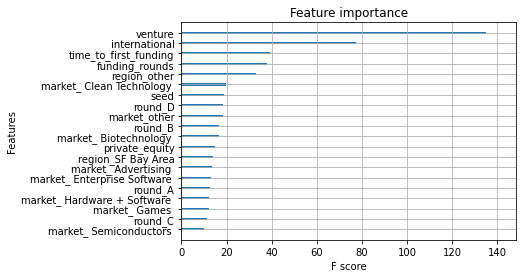

In [104]:
from xgboost import plot_importance
plot_importance(xgb_best, max_num_features=20, importance_type=f, 
                show_values=False)
plt.show()

### ExtraTrees

In [106]:
ext_param_grid = {'criterion':['entropy','gini'],
              'max_depth':[15,20,25],
              'min_samples_leaf': [1,5],
              'class_weight': ['balanced'],
              'max_features': ['auto']
             }

ext = ExtraTreesClassifier(random_state=42)

grid_ext = GridSearchCV(ext, ext_param_grid, cv = 5, scoring='recall') 
grid_ext.fit(X_train_processed, y_train)

grid_ext.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 5}

In [107]:
ext_grid = ExtraTreesClassifier(random_state=42, class_weight='balanced',
                                criterion='gini', max_depth= 25,
                                max_features='auto', min_samples_leaf= 5)
customPipe(ext_grid, 'ext_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.750504,0.711423,0.678626,0.644868,0.714093,0.682887,0.687455,0.536315,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.595190,1.000000,0.645652,1.000000,0.735604,0.713127,0.583713,RandomForestClassifier(random_state=42)
dtc,1.000000,0.551102,1.000000,0.554435,1.000000,0.641525,0.627050,0.489081,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.573146,1.000000,0.612420,1.000000,0.706407,0.685075,0.549577,ExtraTreesClassifier(random_state=42)
xgb,0.911903,0.605210,0.907327,0.626556,0.925074,0.708029,0.691570,0.552834,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.749159,0.713427,0.720103,0.689922,0.765756,0.740470,0.736141,0.592488,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.815064,0.811623,0.708151,0.694683,0.729781,0.711273,0.727338,0.569052,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.760592,0.705411,0.723377,0.669202,0.766027,0.717762,0.715784,0.568235,"ExtraTreesClassifier(class_weight='balanced', ..."


### Decision Tree**

In [109]:
dtc_param_grid = {'criterion':['gini','entropy'],
                  'max_depth':[5,10,15],
                  'min_samples_leaf': [15,20,25],
                  'class_weight': [None, 'balanced']
             }

dtc = DecisionTreeClassifier(random_state=42)

grid_dtc = GridSearchCV(dtc, dtc_param_grid, cv = 5, scoring='recall') 
grid_dtc.fit(X_train_processed, y_train)

grid_dtc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 20}

In [117]:
dtc_best = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                  criterion='gini', max_depth= 5,
                                  min_samples_leaf= 20)

dtc_best.fit(X_train_processed, y_train)
customPipe(dtc_grid, 'dtc_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.750504,0.711423,0.678626,0.644868,0.714093,0.682887,0.687455,0.536315,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.595190,1.000000,0.645652,1.000000,0.735604,0.713127,0.583713,RandomForestClassifier(random_state=42)
dtc,1.000000,0.551102,1.000000,0.554435,1.000000,0.641525,0.627050,0.489081,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.573146,1.000000,0.612420,1.000000,0.706407,0.685075,0.549577,ExtraTreesClassifier(random_state=42)
xgb,0.911903,0.605210,0.907327,0.626556,0.925074,0.708029,0.691570,0.552834,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.741762,0.711423,0.708641,0.685328,0.754666,0.735604,0.731733,0.587096,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.815064,0.811623,0.708151,0.694683,0.729781,0.711273,0.727338,0.569052,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.760592,0.705411,0.723377,0.669202,0.766027,0.717762,0.715784,0.568235,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.738399,0.735471,0.701149,0.689202,0.746822,0.731549,0.732177,0.583943,DecisionTreeClassifier(class_weight='balanced'...


#### Feature Importance

In [118]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, dtc_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_dtc = pd.DataFrame(feats.items())

feats_dtc.columns = ['col', 'feat_importance']
feats_dtc = feats_dtc.sort_values(by=['feat_importance'], ascending=False)
feats_dtc_30 = feats_dtc[:30]

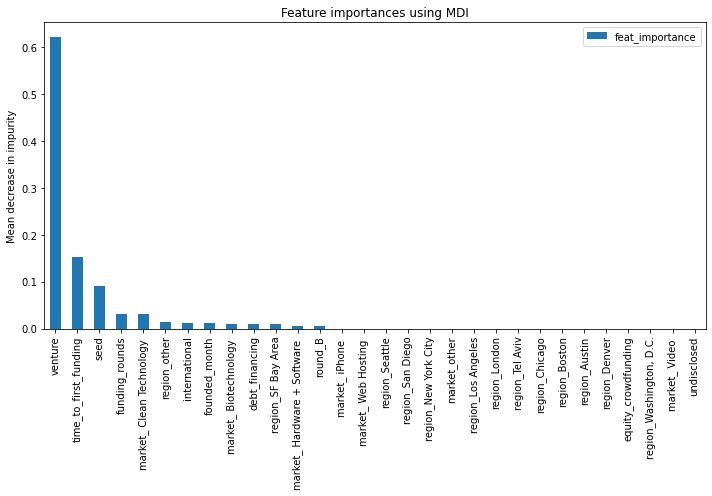

In [119]:
fig, ax = plt.subplots(figsize = (10,7))
feats_dtc_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_dtc_30['col'])
fig.tight_layout()

## Final Model

* XG Boost is the best model, with ~80% recall, 70% accuracy and 70% AUC
* Random Forest comes in second with --
* Now that we have narrowed down the best models, we will run then with reduced features & SMOTE to see if that generates any improvement

In [135]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac, y_ac)

### Feature Reduction

In [123]:
# top 20 features
X_train_xg = X_train_processed[list(feats_xg['col'][:20])]
X_train_dtc = X_train_processed[list(feats_dtc['col'][:20])]

X_test_xg = X_test_processed[list(feats_xg['col'][:20])]
X_test_dtc = X_test_processed[list(feats_dtc['col'][:20])]

In [125]:
# XG Boost
final_model = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                            subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

final_model.fit(X_train_xg, y_train)

y_hat_train = final_model.predict(X_train_xg)
y_hat_test = final_model.predict(X_test_xg)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7942165433759247
Testing Recall:  0.7995991983967936


Training F1:  0.6920597714620569
Testing F1:  0.6861564918314704


ROC AUC:  0.7192818880267347
PR AUC:  0.5615850492452479


Training Accuracy:  0.7157154449553692
Testing Accuracy:  0.7039740470397404


In [124]:
# Decision Trees - 2nd place
final_model = dtc_best
final_model.fit(X_train_dtc, y_train)

y_hat_train = final_model.predict(X_train_dtc)
y_hat_test = final_model.predict(X_test_dtc)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7081371889710827
Testing Recall:  0.6913827655310621


Training F1:  0.6929911154985193
Testing F1:  0.6660231660231661


ROC AUC:  0.7149011920298363
PR AUC:  0.5690830795510653


Training Accuracy:  0.7476332161211794
Testing Accuracy:  0.7193836171938361


Feature reduction doesn't improve the models.

### SMOTE

In [1379]:
#Using SMOTE to further reduce class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_processed, y_train) 

In [1376]:
final_model_smote = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                                  subsample=0.7, learning_rate=0.2)

final_model_smote.fit(X_train_resampled, y_train_resampled)

y_hat_train = final_model_smote.predict(X_train_resampled)
y_hat_test = final_model_smote.predict(X_test_processed)

print_scores(y_train_resampled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7515837104072398
Testing Recall:  0.717434869739479


Training F1:  0.7538007714998864
Testing F1:  0.6878001921229587


ROC AUC:  0.7333768354146988
PR AUC:  0.5882328757316215


Training Accuracy:  0.754524886877828
Testing Accuracy:  0.7364152473641524


### Model Selection

In [133]:
final_model = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                            subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

customPipe(final_model, 'final_model', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr_base,0.750504,0.711423,0.678626,0.644868,0.714093,0.682887,0.687455,0.536315,"LogisticRegression(class_weight='balanced', ra..."
rf,1.000000,0.595190,1.000000,0.645652,1.000000,0.735604,0.713127,0.583713,RandomForestClassifier(random_state=42)
dtc,1.000000,0.551102,1.000000,0.554435,1.000000,0.641525,0.627050,0.489081,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.573146,1.000000,0.612420,1.000000,0.706407,0.685075,0.549577,ExtraTreesClassifier(random_state=42)
xgb,0.911903,0.605210,0.907327,0.626556,0.925074,0.708029,0.691570,0.552834,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.741762,0.711423,0.708641,0.685328,0.754666,0.735604,0.731733,0.587096,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.815064,0.811623,0.708151,0.694683,0.729781,0.711273,0.727338,0.569052,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.760592,0.705411,0.723377,0.669202,0.766027,0.717762,0.715784,0.568235,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.738399,0.735471,0.701149,0.689202,0.746822,0.731549,0.732177,0.583943,DecisionTreeClassifier(class_weight='balanced'...


In [131]:
# storing dataframe for easy access
scores_final = scores
scores_final.to_csv('final_scores.csv')
scores_final.sort_values(by=['recall_test'], ascending=False)[1:]

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
final_model,0.815064,0.811623,0.708151,0.694683,0.729781,0.711273,0.727338,0.569052,"XGBClassifier(base_score=0.5, booster='gbtree'..."
dtc_best,0.738399,0.735471,0.701149,0.689202,0.746822,0.731549,0.732177,0.583943,DecisionTreeClassifier(class_weight='balanced'...
lr_base,0.750504,0.711423,0.678626,0.644868,0.714093,0.682887,0.687455,0.536315,"LogisticRegression(class_weight='balanced', ra..."
rf_best,0.741762,0.711423,0.708641,0.685328,0.754666,0.735604,0.731733,0.587096,RandomForestClassifier(class_weight='balanced'...
ext_best,0.760592,0.705411,0.723377,0.669202,0.766027,0.717762,0.715784,0.568235,"ExtraTreesClassifier(class_weight='balanced', ..."
xgb,0.911903,0.605210,0.907327,0.626556,0.925074,0.708029,0.691570,0.552834,"XGBClassifier(base_score=0.5, booster='gbtree'..."
rf,1.000000,0.595190,1.000000,0.645652,1.000000,0.735604,0.713127,0.583713,RandomForestClassifier(random_state=42)
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
ext,1.000000,0.573146,1.000000,0.612420,1.000000,0.706407,0.685075,0.549577,ExtraTreesClassifier(random_state=42)
dtc,1.000000,0.551102,1.000000,0.554435,1.000000,0.641525,0.627050,0.489081,DecisionTreeClassifier(random_state=42)


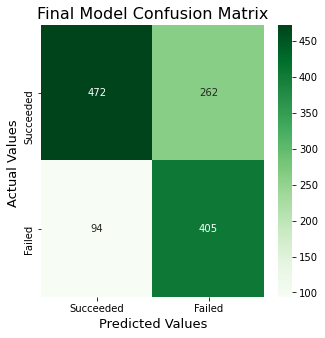

In [136]:
# visualizing predictions

y_hat_test = final_model.predict(X_test_processed)

conf_matrix = confusion_matrix(y_test, y_hat_test)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Succeeded','Failed'])
ax.yaxis.set_ticklabels(['Succeeded','Failed'])

## Display the visualization of the Confusion Matrix.
plt.show()